# Using custom graphs

`gwlearn`'s geographically weighted modelling framework is built on top of `libpysal.graph.Graph` objects, which are typically generated on-the-fly based on the bandwidth and kernel specification. However, you can easily derive the graph in other way and use it wihtin the model, instead of relying on its limited distance and KNN builders. 

Below is a basic example using linear regression and a graph redived from travel cost.

In [ ]:
import geodatasets
import geopandas as gpd
import pandarm
from libpysal.graph import Graph

from gwlearn.linear_model import GWLinearRegression


Get some data you want to model. This dataset is assumed to contain both dependent and independent variables.

In [10]:
df = gpd.read_file(geodatasets.get_path("geoda Cincinnati"))

Generate a `pandarm.Network` based on the extent of the dataset. This will automatically pull the data for street network from OpenStretMap and prepare a network that can be later queried. All points will be linked to this network and accessibility will be measured alongside its edges.

In [11]:
network = pandarm.Network.from_gdf(df)

/Users/martin/dev/pandarm/pandarm/loaders/osm.py:68: UserWarning: GeoDataFrame is stored in coordinate system PROJCS["Lambert_Conformal_Conic",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",-82.5],PARAMETER["standard_parallel_1",40.0333333333333],PARAMETER["standard_parallel_2",38.7333333333333],PARAMETER["false_easting",1968500],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] so the pandana.Network will also be stored in this system
  warn(


Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6004
Setting CH edge vector of size 17060
Range graph removed 17492 edges of 34120
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


Use the network to build a graph with a set distance threshold and a kernel transforming the actual distance to a distance decay weight.

In [ ]:
G = Graph.build_travel_cost(
    df.set_geometry(df.representative_point()), network, threshold=1500, kernel="bisquare"
)

Check the properties of the resulting graph. You can see that on average, you have approximately 130 neighbors.

In [14]:
G.summary()

Graph Summary Statistics
========================
Graph indexed by:
 [0, 1, 2, 3, 4, ...]
==============================================================
Number of nodes:                                           457
Number of edges:                                         60055
Number of connected components:                              1
Number of isolates:                                          0
Number of non-zero edges:                                60055
Percentage of non-zero edges:                           28.76%
Number of asymmetries:                            NA
--------------------------------------------------------------
Cardinalities
==============================================================
Mean:                     131    25%:                       80
Standard deviation:        60    50%:                      137
Min:                       13    75%:                      182
Max:                      237
--------------------------------------------------------------
Weights
==============================================================
Mean:                       0    25%:                        0
Standard deviation:         0    50%:                        0
Min:                        0    75%:                        1
Max:                        1
--------------------------------------------------------------
Sum of weights
==============================================================
S0:                                                      20238
S1:                                                      23694
S2:                                                    4546775
--------------------------------------------------------------
Traces
==============================================================
GG:                                                      11847
G'G:                                                     11847
G'G + GG:                                                23694

Fit the regression. 

In [6]:
gwlr = GWLinearRegression(
    graph=G
)
gwlr.fit(
    X=df[
        [
            "AGE_0_5",
            "AGE_5_9",
            "AGE_10_14",
            "AGE_15_19",
            "AGE_20_24",
            "AGE_25_34",
            "AGE_35_44",
            "AGE_45_54",
            "AGE_55_59",
            "AGE_60_64",
            "AGE_65_74",
            "AGE_75_84",
            "AGE_85",
        ]
    ],
    y=df["WHITE"],
)

,bandwidth,None
,fixed,False
,kernel,'bisquare'
,include_focal,True
,geometry,None
,graph,"<Graph of 457...2, 3, 4, ...]>"
,n_jobs,-1
,fit_global_model,True
,keep_models,False
,temp_folder,None
,batch_size,None


Done. Now you can extract whatever the object contain. Like prediction.

In [7]:
gwlr.pred_

0      130.936918
1       17.722581
2       16.968578
3       17.446927
4       46.600476
          ...    
452      5.367919
453      0.447865
454      0.304060
455      1.478682
456      2.567712
Length: 457, dtype: float64

Or local R2.

In [8]:
gwlr.local_r2_

0      0.833815
1      0.986429
2      0.988289
3      0.974424
4      0.983153
         ...   
452    0.797097
453    0.671675
454    0.709559
455    0.796124
456    0.859937
Length: 457, dtype: float64

That can be plotted.

<Axes: >

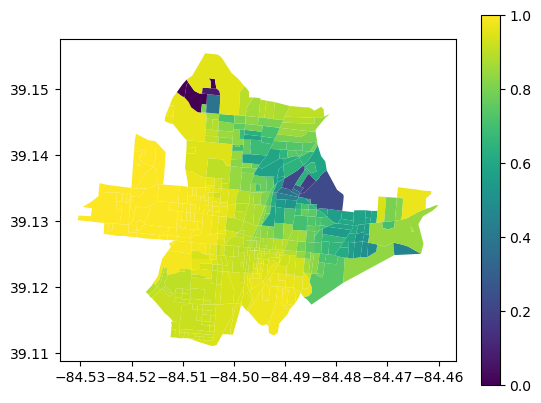

In [9]:
df.plot(gwlr.local_r2_, legend=True, vmin=0, vmax=1)